In [1]:
from math import log, sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import sklearn.metrics as metrics
import psutil
import multiprocessing as mp
from sklearn.utils import class_weight
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import roc_auc_score, cohen_kappa_score, classification_report
from collections import Counter
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")
colors = np.array(['#0101DF','#DF0101','#01DF01'])

time0 = time.time()
rs = 42
def compute_metrics (y_te2,y_p,string):
    print('\n %s'%string)
    print('CONFUSION MATRIX')
    print(metrics.confusion_matrix(y_te2,y_p))
    print(classification_report(y_te2, y_p))
    print('ROC AUC: %2.2f'%roc_auc_score(y_te2,y_p))
    print('Cohens kappa: %f' %cohen_kappa_score(y_te2, y_p))

def plotting_ROC_curve(X_te,y_te,model):
    plt.figure()
    metrics.plot_roc_curve(model,X_te,y_te)
    plt.plot([0,1],[0,1],label='baseline',c='red')
    plt.legend(loc='lower right')
    plt.show()

def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

def adaboost(X_tr, y_tr, X_te, y_te):
    model = AdaBoostClassifier(random_state=rs)
    model.fit(X_tr,y_tr)
    y_pred = model.predict(X_te)
    print(model.feature_importances_)
    compute_metrics(y_te,y_pred,'ADABOOST')
    plotting_ROC_curve(X_te,y_te,model=model)


def RandomForest (X_tr,y_tr,X_te,y_te,cw):
    for i in range(2,4):
        print('dep: '+str(i))
        #RF por defecto utiliza 100 árboles de decisión. Este parámetro se cambia con n_estimators
        rfc = RandomForestClassifier(max_depth=i, random_state=rs,verbose=True,n_jobs=-1,
                                     class_weight=dict(enumerate(cw)))
        rfc.fit(X_tr,y_tr)
        plotting_ROC_curve(X_te,y_te,model=rfc)
        y_pred = rfc.predict(X_te)
        print(rfc.feature_importances_)
        compute_metrics(y_te,y_pred,'RANDOM FOREST')

def CB(X_tr, y_tr, X_te, y_te):
    Cvar = [0.01,0.1,0.5,0.9]
    for i in range(0,len(Cvar)):
            model = CatBoostClassifier(random_state=rs,verbose=1,learning_rate=Cvar[i],max_depth=2)
            model.fit(X_tr,y_tr)
            y_pred = model.predict(X_te)
            compute_metrics(y_te,y_pred,'CatBoost (learning_rate=%1.2f)'%Cvar[i])
            #plotting_ROC_curve(X_te,y_te,model=model)
        
def xgboost(X_tr, y_tr, X_te, y_te):
    model = XGBClassifier(random_state=rs,n_jobs=-1)
    model.fit(X_tr,y_tr)
    y_pred = model.predict(X_te)
    print(model.feature_importances_)
    compute_metrics(y_te,y_pred,'XGBoost')
    plotting_ROC_curve(X_te,y_te,model=model)
    
def DT(X_tr, y_tr, X_te, y_te,cw):
    for i in range(1,3):
        model = DecisionTreeClassifier(random_state=rs,max_depth=i,class_weight=dict(enumerate(cw)))
        model.fit(X_tr,y_tr)
        y_pred = model.predict(X_te)
        print(model.feature_importances_)
        compute_metrics(y_te,y_pred,'DECISION TREE')
        plotting_ROC_curve(X_te,y_te,model=model)
    
def KNN(X_tr, y_tr, X_te, y_te):
    nei = [3,25,50]
    for i in range(0,len(nei)):
        model = KNeighborsClassifier(n_neighbors=nei[i],weights='distance',n_jobs=-1)
        model.fit(X_tr,y_tr)
        y_pred = model.predict(X_te)
        compute_metrics(y_te,y_pred,'K-Neighbours (n_neighbors:%i)'%nei[i])
        plotting_ROC_curve(X_te,y_te,model=model)
    
def SVCL(X_tr, y_tr, X_te, y_te):
    Cvar = [0.01,0.1,0.5,0.9]
    for i in range(0,len(Cvar)):
            model = SVC(C=Cvar[i],kernel='sigmoid',degree=3,max_iter=100,random_state=rs,verbose=True)
            model.fit(X_tr,y_tr)
            y_pred = model.predict(X_te)
            compute_metrics(y_te,y_pred,'SVCL (C=%1.2f)'%Cvar[i])
            plotting_ROC_curve(X_te,y_te,model=model)
    
def BalancedRF(X_tr,y_tr,X_te,y_te,cw):
    for i in range(1,3):
        print('dep: '+str(i))
        brfc = BalancedRandomForestClassifier(max_depth=i, random_state=rs,verbose=True,n_jobs=-1,class_weight=dict(enumerate(cw)))
        brfc.fit(X_tr,y_tr)
        y_pred = brfc.predict(X_te)
        print(brfc.feature_importances_)
        compute_metrics(y_te,y_pred,'BALANCED RANDOM FOREST')
        plotting_ROC_curve(X_te,y_te,model=brfc)

def EasyEnsamble(X_tr, y_tr, X_te, y_te):
    nest = [10,25,50]
    for i in range(0,len(nest)):
        model = EasyEnsembleClassifier(n_estimators=nest[i],warm_start=True,n_jobs=-1,random_state=rs, verbose=1,replacement=True)
        model.fit(X_tr,y_tr)
        y_pred = model.predict(X_te)
        compute_metrics(y_te,y_pred,'Easy Ensemble Classifier (n_estimators: %i)'%nest[i])
        plotting_ROC_curve(X_te,y_te,model=model)
    
def RUSBoost(X_tr, y_tr, X_te, y_te):
    nest = [10,25,50]
    for i in range(0,len(nest)):
        model = RUSBoostClassifier(n_estimators=nest[i],learning_rate=0.01,replacement=True,random_state=rs)
        model.fit(X_tr,y_tr)
        y_pred = model.predict(X_te)
        print(model.feature_importances_)
        compute_metrics(y_te,y_pred,'RUS Boost Classifier (n_estimators: %i)'%nest[i])
        plotting_ROC_curve(X_te,y_te,model=model)

def Ratio10(y,string):
    suma = Counter(y)[0]+Counter(y)[1]
    print('\n'+string)  
    print(Counter(y))
    print('0: %3.2f%%\n1: %3.2f%%' % (100*Counter(y)[0]/suma,100*Counter(y)[1]/suma))

def histo(data,var):
    fig=plt.figure()
    sns.countplot(var,data=data,palette=colors)
    plt.title('0/1 Distribution (0: No Stalling || 1: Stalling Event',fontsize=14)
    plt.show()

Using TensorFlow backend.


Index(['∆t', 'pkt_len', 'tcp_hea_len', 'tcp_flag_ack', 'tcp_flag_rst',
       'tcp_flag_syn', 'tcp_win_si2', 'delay', 'capture', 'stalling_event'],
      dtype='object')

dataset[stalling_event]
Counter({0: 1426905, 1: 113031})
0: 92.66%
1: 7.34%


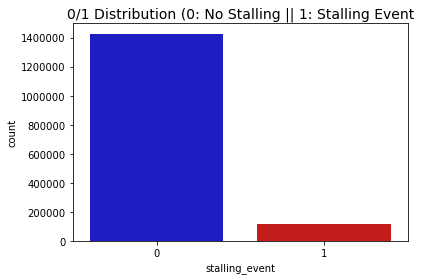

In [2]:
dataset = pd.read_csv('../../output/df_general.csv', sep=',')
split = 0.8
del dataset['No.']
del dataset['Protocol']
del dataset['tcp_flag_cwr']
del dataset['tcp_flag_ecn']
del dataset['tcp_flag_urg']
del dataset['ip_len']
del dataset['tcp_flag_psh']
del dataset['tcp_flag_fin']
del dataset['prebuffering']
del dataset['Time']

dataset = dataset.fillna(dataset.mean())

print(dataset.columns)
Ratio10(dataset['stalling_event'],'dataset[stalling_event]')
histo(dataset,'stalling_event')

(1539936, 10)
(1538832, 10)
0.4992

dataset[stalling_event]
Counter({0: 1425825, 1: 113007})
0: 92.66%
1: 7.34%
Index(['∆t', 'pkt_len', 'tcp_hea_len', 'tcp_flag_ack', 'tcp_flag_rst',
       'tcp_flag_syn', 'tcp_win_si2', 'delay', 'capture', 'stalling_event'],
      dtype='object')
       ∆t  pkt_len  tcp_hea_len  tcp_flag_ack  tcp_flag_rst  tcp_flag_syn  \
0  0.0000       66         32.0           0.0           0.0           1.0   
1  0.0327       66         32.0           1.0           0.0           1.0   
2  0.0002       54         20.0           1.0           0.0           0.0   
3  0.0017      396         20.0           1.0           0.0           0.0   
4  0.0363      551         20.0           1.0           0.0           0.0   

   tcp_win_si2  
0       8192.0  
1      65000.0  
2        256.0  
3        256.0  
4      64658.0  
0    0
1    0
2    0
3    0
4    0
Name: stalling_event, dtype: int64


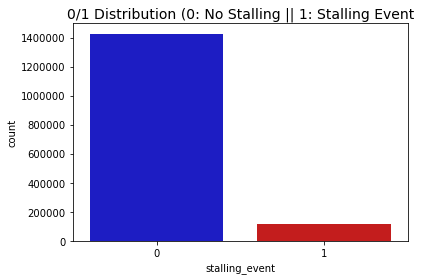

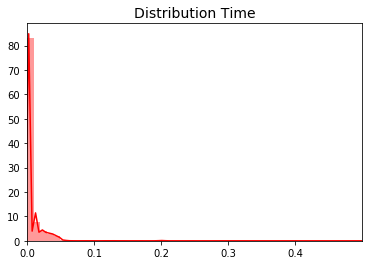

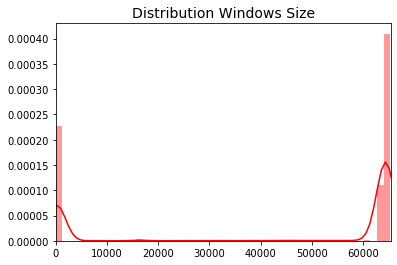

In [3]:
id = list(dataset[dataset['∆t']>0.5].index)
print(dataset.shape)
dataset = dataset.drop(id)
print(dataset.shape)
print(max(dataset['∆t']))
Ratio10(dataset['stalling_event'],'dataset[stalling_event]')
histo(dataset,'stalling_event')

time_val = dataset['∆t'].values
win_val = dataset['tcp_win_si2'].values

fig = plt.figure()
sns.distplot(time_val,color='r')
plt.title('Distribution Time',fontsize=14)
plt.xlim([min(time_val),max(time_val)])

fig = plt.figure()
sns.distplot(win_val,color='r')
plt.title('Distribution Windows Size',fontsize=14)
plt.xlim([min(win_val),max(win_val)])

print(dataset.columns)
y = dataset['stalling_event']
X = dataset.drop(['delay','capture','stalling_event'],axis=1)
print(X.head())
print(y.head())

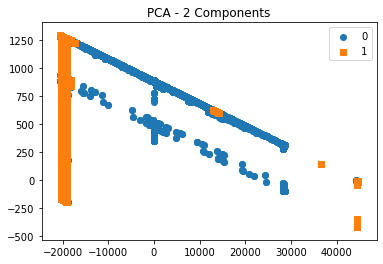

In [4]:
pca = PCA(n_components=2)
X_train_pca=pca.fit_transform(X)
plot_2d_space(X_train_pca, y,'PCA - 2 Components')

In [5]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X.values,y.values)
Ratio10(y_rus,'y_rus')
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus,
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                    stratify=y_rus)

Ratio10(y_train_rus,'y_train_rus')
Ratio10(y_test_rus,'y_test_rus')

rus_cw = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train_rus),
                                            y_train_rus)


y_rus
Counter({0: 113007, 1: 113007})
0: 50.00%
1: 50.00%

y_train_rus
Counter({1: 90406, 0: 90405})
0: 50.00%
1: 50.00%

y_test_rus
Counter({0: 22602, 1: 22601})
0: 50.00%
1: 50.00%


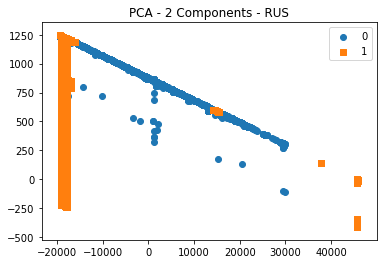

In [6]:
pca = PCA(n_components=2)
X_rus_pca=pca.fit_transform(X_rus)
plot_2d_space(X_rus_pca, y_rus.T.ravel(),'PCA - 2 Components - RUS')

In [7]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X.values,y.values)
Ratio10(y_ros,'y_ros')
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_ros, y_ros,
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                    stratify=y_ros)

Ratio10(y_train_ros,'y_train_ros')
Ratio10(y_test_ros,'y_test_ros')

ros_cw = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train_ros),
                                            y_train_ros)


y_ros
Counter({0: 1425825, 1: 1425825})
0: 50.00%
1: 50.00%

y_train_ros
Counter({1: 1140660, 0: 1140660})
0: 50.00%
1: 50.00%

y_test_ros
Counter({1: 285165, 0: 285165})
0: 50.00%
1: 50.00%


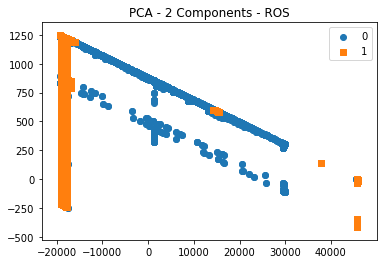

In [8]:
pca = PCA(n_components=2)
X_ros_pca=pca.fit_transform(X_ros)
plot_2d_space(X_ros_pca, y_ros.T.ravel(),'PCA - 2 Components - ROS')

In [9]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority',random_state=rs,n_jobs=-1)
X_sm, y_sm = smote.fit_sample(X.values, y.values)
Ratio10(y_sm,'y_sm')
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm,
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                    stratify=y_sm)

Ratio10(y_train_sm,'y_train_sm')
Ratio10(y_test_sm,'y_test_sm')

sm_cw = class_weight.compute_class_weight('balanced',
                                          np.unique(y_train_sm),
                                          y_train_sm)


y_sm
Counter({0: 1425825, 1: 1425825})
0: 50.00%
1: 50.00%

y_train_sm
Counter({1: 1140660, 0: 1140660})
0: 50.00%
1: 50.00%

y_test_sm
Counter({1: 285165, 0: 285165})
0: 50.00%
1: 50.00%


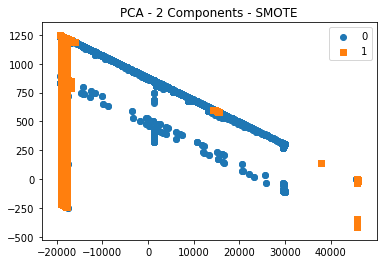

In [10]:
pca = PCA(n_components=2)
X_sm_pca=pca.fit_transform(X_sm)
plot_2d_space(X_sm_pca, y_sm.T.ravel(),'PCA - 2 Components - SMOTE')

In [11]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy='minority',random_state=rs,n_jobs=-1)
X_ad, y_ad = adasyn.fit_sample(X.values, y.values)
Ratio10(y_ad,'y_ad')
X_train_ad, X_test_ad, y_train_ad, y_test_ad = train_test_split(X_ad, y_ad,
                                                                test_size=0.2,
                                                                random_state=42,
                                                                stratify=y_ad)

Ratio10(y_train_ad,'y_train_ad')
Ratio10(y_test_ad,'y_test_ad')

ad_cw = class_weight.compute_class_weight('balanced',
                                          np.unique(y_train_ad),
                                          y_train_ad)


y_ad
Counter({1: 1439653, 0: 1425825})
0: 49.76%
1: 50.24%

y_train_ad
Counter({1: 1151722, 0: 1140660})
0: 49.76%
1: 50.24%

y_test_ad
Counter({1: 287931, 0: 285165})
0: 49.76%
1: 50.24%


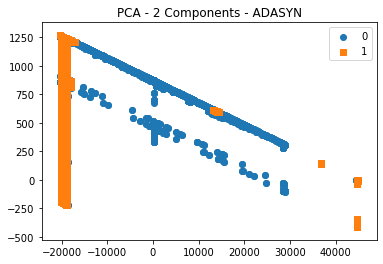

In [12]:
pca = PCA(n_components=2)
X_ad_pca=pca.fit_transform(X_ad)
plot_2d_space(X_ad_pca, y_ad.T.ravel(),'PCA - 2 Components - ADASYN')

dep: 2
[0.16845107 0.04259342 0.05122952 0.18096477 0.15799973 0.04319313
 0.35556837]

 RANDOM FOREST
CONFUSION MATRIX
[[14317  8285]
 [11816 10785]]
              precision    recall  f1-score   support

           0       0.55      0.63      0.59     22602
           1       0.57      0.48      0.52     22601

    accuracy                           0.56     45203
   macro avg       0.56      0.56      0.55     45203
weighted avg       0.56      0.56      0.55     45203

ROC AUC: 0.56
Cohens kappa: 0.110631
dep: 3
[0.1415482  0.06285845 0.06253709 0.12788738 0.1120294  0.03256244
 0.46057704]

 RANDOM FOREST
CONFUSION MATRIX
[[15489  7113]
 [12365 10236]]
              precision    recall  f1-score   support

           0       0.56      0.69      0.61     22602
           1       0.59      0.45      0.51     22601

    accuracy                           0.57     45203
   macro avg       0.57      0.57      0.56     45203
weighted avg       0.57      0.57      0.56     45203

ROC AUC

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel

<Figure size 432x288 with 0 Axes>

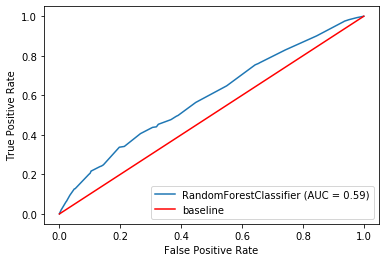

<Figure size 432x288 with 0 Axes>

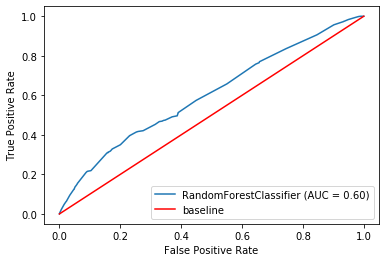

In [13]:
#RANDOM UNDER SAMPLING
RandomForest(X_train_rus,y_train_rus,X_test_rus,y_test_rus,rus_cw)

[0. 0. 0. 0. 0. 0. 1.]

 DECISION TREE
CONFUSION MATRIX
[[14592  8010]
 [12411 10190]]
              precision    recall  f1-score   support

           0       0.54      0.65      0.59     22602
           1       0.56      0.45      0.50     22601

    accuracy                           0.55     45203
   macro avg       0.55      0.55      0.54     45203
weighted avg       0.55      0.55      0.54     45203

ROC AUC: 0.55
Cohens kappa: 0.096472
[0. 0. 0. 0. 0. 0. 1.]

 DECISION TREE
CONFUSION MATRIX
[[17259  5343]
 [14316  8285]]
              precision    recall  f1-score   support

           0       0.55      0.76      0.64     22602
           1       0.61      0.37      0.46     22601

    accuracy                           0.57     45203
   macro avg       0.58      0.57      0.55     45203
weighted avg       0.58      0.57      0.55     45203

ROC AUC: 0.57
Cohens kappa: 0.130183


<Figure size 432x288 with 0 Axes>

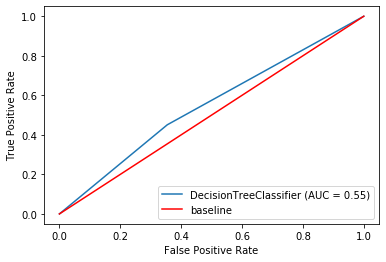

<Figure size 432x288 with 0 Axes>

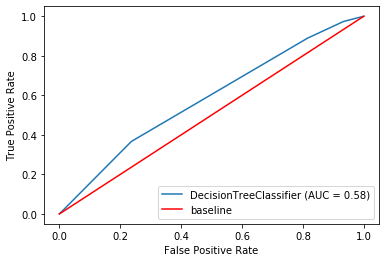

In [14]:

DT(X_train_rus,y_train_rus,X_test_rus,y_test_rus,rus_cw)

dep: 1
[0.1  0.   0.07 0.25 0.22 0.07 0.29]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[14521  8081]
 [12156 10445]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59     22602
           1       0.56      0.46      0.51     22601

    accuracy                           0.55     45203
   macro avg       0.55      0.55      0.55     45203
weighted avg       0.55      0.55      0.55     45203

ROC AUC: 0.55
Cohens kappa: 0.104613
dep: 2
[0.1357004  0.04133047 0.06671581 0.19482095 0.15931791 0.03253667
 0.3695778 ]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[14285  8317]
 [11798 10803]]
              precision    recall  f1-score   support

           0       0.55      0.63      0.59     22602
           1       0.57      0.48      0.52     22601

    accuracy                           0.56     45203
   macro avg       0.56      0.56      0.55     45203
weighted avg       0.56      0.56      0.55     45203

ROC AUC: 0.56
Cohens kappa: 0.11

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel

<Figure size 432x288 with 0 Axes>

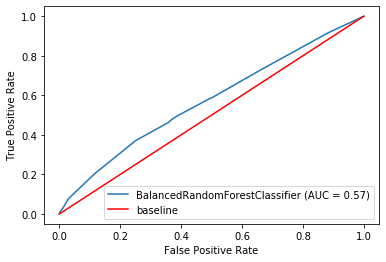

<Figure size 432x288 with 0 Axes>

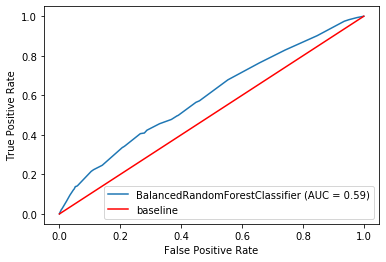

In [15]:
BalancedRF(X_train_rus,y_train_rus,X_test_rus,y_test_rus,rus_cw)

dep: 2
[0.16636091 0.03904542 0.0408857  0.18212891 0.14901141 0.05401371
 0.36855394]

 RANDOM FOREST
CONFUSION MATRIX
[[182924 102241]
 [153512 131653]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.46      0.51    285165

    accuracy                           0.55    570330
   macro avg       0.55      0.55      0.55    570330
weighted avg       0.55      0.55      0.55    570330

ROC AUC: 0.55
Cohens kappa: 0.103140
dep: 3
[0.14237805 0.05947553 0.05683657 0.14758584 0.11242004 0.03610594
 0.44519803]

 RANDOM FOREST
CONFUSION MATRIX
[[207260  77905]
 [165611 119554]]
              precision    recall  f1-score   support

           0       0.56      0.73      0.63    285165
           1       0.61      0.42      0.50    285165

    accuracy                           0.57    570330
   macro avg       0.58      0.57      0.56    570330
weighted avg       0.58      0.57      0.56    570330


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel

<Figure size 432x288 with 0 Axes>

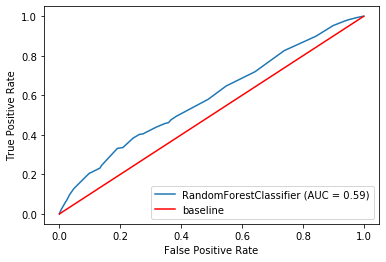

<Figure size 432x288 with 0 Axes>

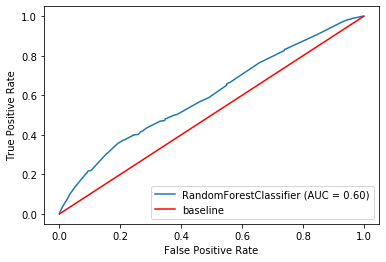

In [16]:
#RANDOM OVER SAMPLING
RandomForest(X_train_ros,y_train_ros,X_test_ros,y_test_ros,ros_cw)


[0. 0. 0. 0. 0. 0. 1.]

 DECISION TREE
CONFUSION MATRIX
[[183725 101440]
 [156838 128327]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.45      0.50    285165

    accuracy                           0.55    570330
   macro avg       0.55      0.55      0.54    570330
weighted avg       0.55      0.55      0.54    570330

ROC AUC: 0.55
Cohens kappa: 0.094286
[0. 0. 0. 0. 0. 0. 1.]

 DECISION TREE
CONFUSION MATRIX
[[217311  67854]
 [180779 104386]]
              precision    recall  f1-score   support

           0       0.55      0.76      0.64    285165
           1       0.61      0.37      0.46    285165

    accuracy                           0.56    570330
   macro avg       0.58      0.56      0.55    570330
weighted avg       0.58      0.56      0.55    570330

ROC AUC: 0.56
Cohens kappa: 0.128108


<Figure size 432x288 with 0 Axes>

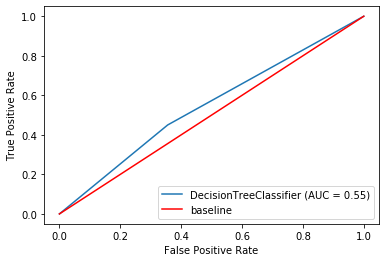

<Figure size 432x288 with 0 Axes>

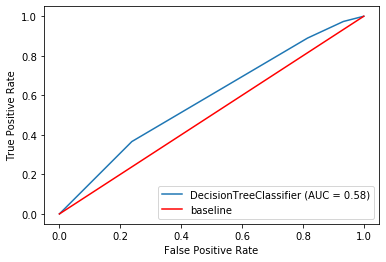

In [17]:
DT(X_train_ros,y_train_ros,X_test_ros,y_test_ros,ros_cw)

dep: 1
[0.1  0.   0.06 0.25 0.22 0.08 0.29]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[182924 102241]
 [153512 131653]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.46      0.51    285165

    accuracy                           0.55    570330
   macro avg       0.55      0.55      0.55    570330
weighted avg       0.55      0.55      0.55    570330

ROC AUC: 0.55
Cohens kappa: 0.103140
dep: 2
[0.12952651 0.03990321 0.04799661 0.19863263 0.17023544 0.04416532
 0.36954029]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[194066  91099]
 [159670 125495]]
              precision    recall  f1-score   support

           0       0.55      0.68      0.61    285165
           1       0.58      0.44      0.50    285165

    accuracy                           0.56    570330
   macro avg       0.56      0.56      0.55    570330
weighted avg       0.56      0.56      0.55    570330

ROC AUC: 0.56
Cohens kap

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel

<Figure size 432x288 with 0 Axes>

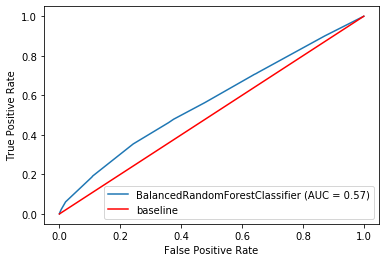

<Figure size 432x288 with 0 Axes>

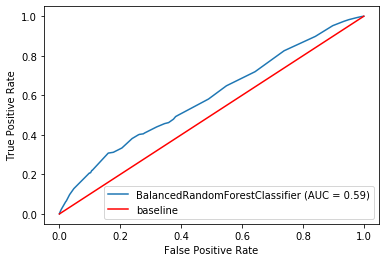

In [18]:
BalancedRF(X_train_ros,y_train_ros,X_test_ros,y_test_ros,ros_cw)

dep: 2
[0.16074054 0.04019104 0.04063371 0.15282847 0.17686711 0.0558629
 0.37287623]

 RANDOM FOREST
CONFUSION MATRIX
[[182820 102345]
 [153128 132037]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.46      0.51    285165

    accuracy                           0.55    570330
   macro avg       0.55      0.55      0.55    570330
weighted avg       0.55      0.55      0.55    570330

ROC AUC: 0.55
Cohens kappa: 0.104122
dep: 3
[0.14219168 0.06778353 0.05197134 0.12255182 0.12068377 0.04405904
 0.45075882]

 RANDOM FOREST
CONFUSION MATRIX
[[207052  78113]
 [165198 119967]]
              precision    recall  f1-score   support

           0       0.56      0.73      0.63    285165
           1       0.61      0.42      0.50    285165

    accuracy                           0.57    570330
   macro avg       0.58      0.57      0.56    570330
weighted avg       0.58      0.57      0.56    570330



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel

<Figure size 432x288 with 0 Axes>

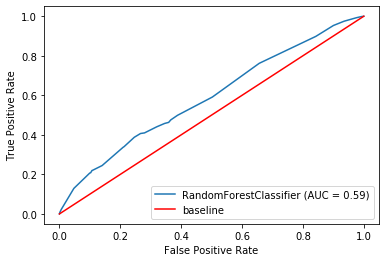

<Figure size 432x288 with 0 Axes>

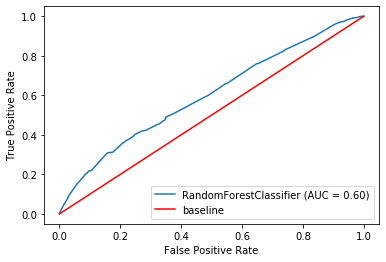

In [19]:
#SMOTE
RandomForest(X_train_sm,y_train_sm,X_test_sm,y_test_sm,sm_cw)


[0. 0. 0. 0. 0. 0. 1.]

 DECISION TREE
CONFUSION MATRIX
[[183725 101440]
 [156687 128478]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.45      0.50    285165

    accuracy                           0.55    570330
   macro avg       0.55      0.55      0.54    570330
weighted avg       0.55      0.55      0.54    570330

ROC AUC: 0.55
Cohens kappa: 0.094815
[0. 0. 0. 0. 0. 0. 1.]

 DECISION TREE
CONFUSION MATRIX
[[217311  67854]
 [180592 104573]]
              precision    recall  f1-score   support

           0       0.55      0.76      0.64    285165
           1       0.61      0.37      0.46    285165

    accuracy                           0.56    570330
   macro avg       0.58      0.56      0.55    570330
weighted avg       0.58      0.56      0.55    570330

ROC AUC: 0.56
Cohens kappa: 0.128764


<Figure size 432x288 with 0 Axes>

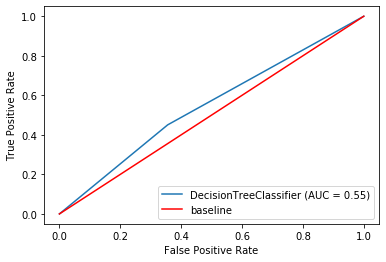

<Figure size 432x288 with 0 Axes>

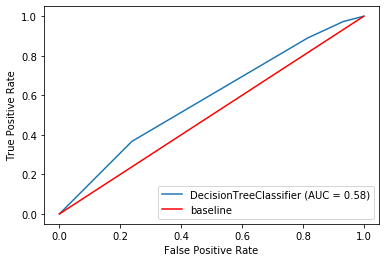

In [20]:
DT(X_train_sm,y_train_sm,X_test_sm,y_test_sm,sm_cw)


dep: 1
[0.1  0.   0.06 0.23 0.24 0.08 0.29]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[182924 102241]
 [153259 131906]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.46      0.51    285165

    accuracy                           0.55    570330
   macro avg       0.55      0.55      0.55    570330
weighted avg       0.55      0.55      0.55    570330

ROC AUC: 0.55
Cohens kappa: 0.104027
dep: 2
[0.12898382 0.04163578 0.04586389 0.17541838 0.18807264 0.04434735
 0.37567813]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[192117  93048]
 [155963 129202]]
              precision    recall  f1-score   support

           0       0.55      0.67      0.61    285165
           1       0.58      0.45      0.51    285165

    accuracy                           0.56    570330
   macro avg       0.57      0.56      0.56    570330
weighted avg       0.57      0.56      0.56    570330

ROC AUC: 0.56
Cohens kap

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   57.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel

<Figure size 432x288 with 0 Axes>

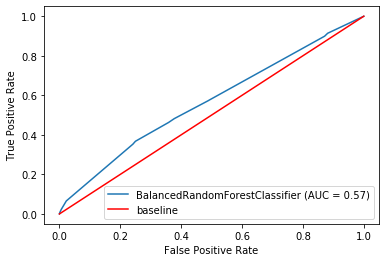

<Figure size 432x288 with 0 Axes>

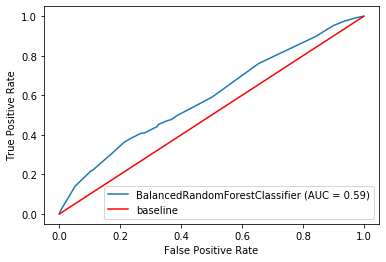

In [21]:
BalancedRF(X_train_sm,y_train_sm,X_test_sm,y_test_sm,sm_cw)

dep: 2
[0.24941946 0.02079768 0.12972516 0.05252851 0.08304403 0.02887841
 0.43560677]

 RANDOM FOREST
CONFUSION MATRIX
[[163909 121256]
 [129092 158839]]
              precision    recall  f1-score   support

           0       0.56      0.57      0.57    285165
           1       0.57      0.55      0.56    287931

    accuracy                           0.56    573096
   macro avg       0.56      0.56      0.56    573096
weighted avg       0.56      0.56      0.56    573096

ROC AUC: 0.56
Cohens kappa: 0.126426
dep: 3
[0.18116972 0.04340834 0.10471513 0.04138333 0.07006945 0.01945168
 0.53980237]

 RANDOM FOREST
CONFUSION MATRIX
[[174899 110266]
 [135751 152180]]
              precision    recall  f1-score   support

           0       0.56      0.61      0.59    285165
           1       0.58      0.53      0.55    287931

    accuracy                           0.57    573096
   macro avg       0.57      0.57      0.57    573096
weighted avg       0.57      0.57      0.57    573096


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel

<Figure size 432x288 with 0 Axes>

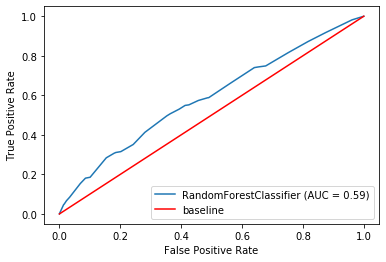

<Figure size 432x288 with 0 Axes>

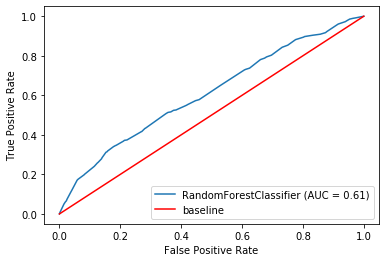

In [22]:
#ADASYN
RandomForest(X_train_ad,y_train_ad,X_test_ad,y_test_ad,ad_cw)

[0. 0. 0. 0. 0. 0. 1.]

 DECISION TREE
CONFUSION MATRIX
[[183725 101440]
 [156798 131133]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.56      0.46      0.50    287931

    accuracy                           0.55    573096
   macro avg       0.55      0.55      0.55    573096
weighted avg       0.55      0.55      0.55    573096

ROC AUC: 0.55
Cohens kappa: 0.099615
[0. 0. 0. 0. 0. 0. 1.]

 DECISION TREE
CONFUSION MATRIX
[[140603 144562]
 [104311 183620]]
              precision    recall  f1-score   support

           0       0.57      0.49      0.53    285165
           1       0.56      0.64      0.60    287931

    accuracy                           0.57    573096
   macro avg       0.57      0.57      0.56    573096
weighted avg       0.57      0.57      0.56    573096

ROC AUC: 0.57
Cohens kappa: 0.130869


<Figure size 432x288 with 0 Axes>

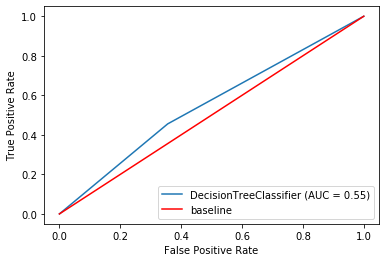

<Figure size 432x288 with 0 Axes>

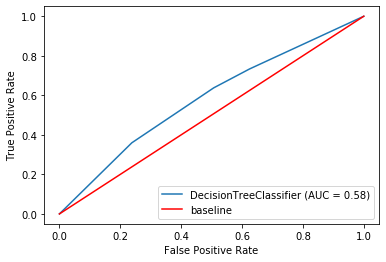

In [23]:
DT(X_train_ad,y_train_ad,X_test_ad,y_test_ad,ad_cw)

dep: 1
[0.18 0.   0.22 0.11 0.13 0.07 0.29]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[182924 102241]
 [154139 133792]]
              precision    recall  f1-score   support

           0       0.54      0.64      0.59    285165
           1       0.57      0.46      0.51    287931

    accuracy                           0.55    573096
   macro avg       0.55      0.55      0.55    573096
weighted avg       0.55      0.55      0.55    573096

ROC AUC: 0.55
Cohens kappa: 0.106041
dep: 2
[0.19543462 0.01947963 0.1380801  0.0566192  0.09206251 0.02493611
 0.47338783]

 BALANCED RANDOM FOREST
CONFUSION MATRIX
[[175471 109694]
 [136556 151375]]
              precision    recall  f1-score   support

           0       0.56      0.62      0.59    285165
           1       0.58      0.53      0.55    287931

    accuracy                           0.57    573096
   macro avg       0.57      0.57      0.57    573096
weighted avg       0.57      0.57      0.57    573096

ROC AUC: 0.57
Cohens kap

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   58.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel

<Figure size 432x288 with 0 Axes>

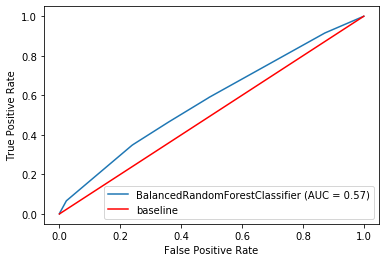

<Figure size 432x288 with 0 Axes>

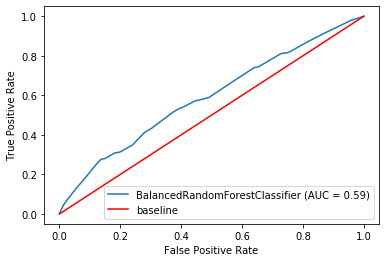

In [24]:
BalancedRF(X_train_ad,y_train_ad,X_test_ad,y_test_ad,ad_cw)

